In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/reducing-commercial-aviation-fatalities/sample_submission.csv
/kaggle/input/reducing-commercial-aviation-fatalities/train.csv
/kaggle/input/reducing-commercial-aviation-fatalities/test.csv


In [2]:
import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import log_loss, accuracy_score, precision_recall_fscore_support
from sklearn.metrics import multilabel_confusion_matrix, confusion_matrix
from sklearn.metrics import classification_report, f1_score
import seaborn as sns
import lightgbm as lgb
from tqdm.notebook import tqdm

#models
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier #Gradient booster classifier
from lightgbm import LGBMClassifier

# 1. Data Exploration and Understanding

In [3]:
dtypes = {"crew": "int8",
          "experiment": "category",
          "time": "float32",
          "seat": "int8",
          "eeg_fp1": "float32",
          "eeg_f7": "float32",
          "eeg_f8": "float32",
          "eeg_t4": "float32",
          "eeg_t6": "float32",
          "eeg_t5": "float32",
          "eeg_t3": "float32",
          "eeg_fp2": "float32",
          "eeg_o1": "float32",
          "eeg_p3": "float32",
          "eeg_pz": "float32",
          "eeg_f3": "float32",
          "eeg_fz": "float32",
          "eeg_f4": "float32",
          "eeg_c4": "float32",
          "eeg_p4": "float32",
          "eeg_poz": "float32",
          "eeg_c3": "float32",
          "eeg_cz": "float32",
          "eeg_o2": "float32",
          "ecg": "float32",
          "r": "float32",
          "gsr": "float32",
          "event": "category",
         }

train_df = pd.read_csv("../input/reducing-commercial-aviation-fatalities/train.csv", dtype=dtypes)
test_df = pd.read_csv("../input/reducing-commercial-aviation-fatalities/test.csv", dtype=dtypes)

Let's see how many crews we are dealing with.

In [4]:
print(train_df.crew.unique())
assert(set(train_df.crew.unique())==set(test_df.crew.unique()))

[ 1  2  3  4  5  6  7  8 13]


Each pilot is identified as occupying one seat (left or right) in one crew (9 crews in total). We generate a unique ID for each pilot.

In [5]:
train_df['pilot'] = 100 * train_df['seat'] + train_df['crew']
test_df['pilot'] = 100 * test_df['seat'] + test_df['crew']
#Add pilots value

We have column 'time' in our data. Let's see if it is organized in a good manner. Take pilot No.1 as an example.

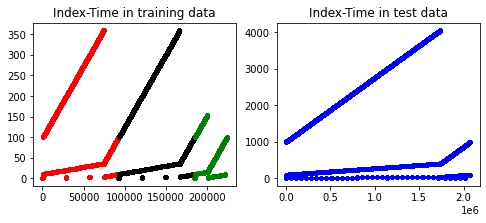

In [6]:
plt.figure(figsize=(8,3))
chunk=train_df[train_df.pilot==1].reset_index()
exp_colors={'SS':'g','CA':'r','DA':'k','LOFT':'b'}
for exp in chunk.experiment.unique():
    exp_chunk=chunk[chunk.experiment==exp]
    plt.subplot(1,2,1)
    plt.scatter(exp_chunk.index,exp_chunk.time.values,alpha=0.5,marker='.',c=exp_colors[exp])
    plt.title('Index-Time in training data')
    
test_chunk=test_df[test_df.pilot==1]
for exp in test_chunk.experiment.unique():
    exp_chunk=test_chunk[test_chunk.experiment==exp]
    plt.subplot(1,2,2)
    plt.scatter(exp_chunk.index,exp_chunk.time.values,alpha=0.5,marker='.',c=exp_colors[exp])
    plt.title('Index-Time in test data')

Looks like we have a dataset shuffled in terms of time. Also, for each experiment time is recalculated. 3 kinds of experiments in training set and 1 in test set. What about we sort by time and plot again? If we get a perfect line, that means we can restore order of data to do more analysis.

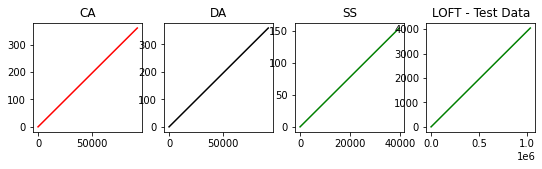

In [7]:
plt.figure(figsize=(9,2))
chunk_sorted = chunk.sort_values(by='time')
for i,exp in enumerate(chunk.experiment.unique()):
    plt.subplot(1,4,i+1)
    exp_chunk=chunk_sorted[chunk_sorted.experiment==exp].reset_index()
    plt.plot(exp_chunk.index,exp_chunk.time,c=exp_colors[exp])
    plt.title(exp)

plt.subplot(1,4,4)
test_chunk = test_chunk.sort_values(by='time').reset_index()
plt.plot(test_chunk.index,test_chunk.time,c=exp_colors[exp])
plt.title('LOFT - Test Data');

As can be seen, after sorting our time data looks perfectly continuous and monotonic. A big progress! Now with this continuous dataframe we can investigate how time interacts with other features. To save space, we show only a few visuals from our collection.

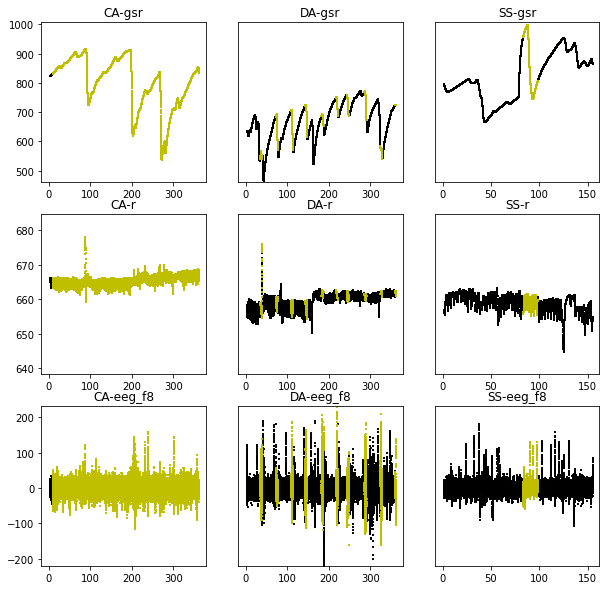

In [8]:
plt.figure(figsize=(10,10)) 
for i,feature in enumerate(['gsr','r','eeg_f8']):
    for j,exp in enumerate(chunk.experiment.unique()):
        plt.subplot(3,3,i*3+j+1)
        exp_chunk=chunk_sorted[chunk_sorted.experiment==exp]
        for event in exp_chunk.event.unique():
            event_chunk=exp_chunk[exp_chunk.event==event]
            plt.scatter(event_chunk.time, event_chunk[feature], c='k' if event=='A' else 'y', marker=',', s=1)

            plt.ylim((chunk[feature].min()*0.99,chunk[feature].max()*1.01))
        plt.title(exp+'-'+feature)
        if j!=0:
            plt.tick_params(
                axis='y',       # changes apply to the x-axis
                which='both',   # both major and minor ticks are affected
                left=False,     # ticks along the bottom edge are off
                labelleft=False)

We can see that our variables are continuous, changing little in short amount of time. Also, events occur suddenly and last for sometime. Lastly, think of our goal: we are predicting events in a new experiment that our model knows nothing about it. All of these indicate that we need to think of a new way to shuffle data into training and validation dataset. Otherwise, suppose we are using random split over one time period, 80% data in this period goes to training set, and 20% goes to validation set. Because data in two pieces are so similar that our classifier learns how to match training data with validation set instead, we are overwhelmingly overfitting and prediction results using validation dataset can be over-optimistic (this is presumably why we can get a perfect prediction against validation set but final submissions usually disappoint us).

My way to cope with this situation is to group data according to time. If we split our data into fragments of several seconds, we are reducing correlation between each group and making it harder for our classifier to "match".

I am assigning groups into 240-sec fragments for illustration purpose because the more groups we have, the longer it takes to calculate group features during feature engineering. And Kaggle has a certain time limit for kernels. As a result, the results here do NOT reflect models for my real submission.

In [9]:
def grouping(df):
    print('Grouping data for {} rows'.format(len(df)))
    df['groupid']=np.nan
    first_available=0  # Ensure a unique ID for every fragment during one experiment of one pilot in the entire dataframe
    interval=240        # variable to control inrerval of each group
    for pilot in tqdm(df.pilot.unique()):
        for exp in df[df.pilot==pilot].experiment.unique():
            chunk=df[(df.pilot==pilot) & (df.experiment==exp)]
            df.loc[chunk.index,'groupid']=(chunk.time//interval).astype(int)+first_available
            first_available+=((int)((chunk.time//interval).max())+1)
grouping(train_df)
grouping(test_df)

Grouping data for 4867421 rows


  0%|          | 0/18 [00:00<?, ?it/s]

Grouping data for 17965143 rows


  0%|          | 0/18 [00:00<?, ?it/s]

In [10]:
def train_test_split_group(X,y,grouping_reference,random_state=0,train_size=0.75):
    from sklearn.model_selection import train_test_split
    groups=grouping_reference.unique()
    groupN=len(groups)
    Gtrain,Gtest=train_test_split(groups,random_state=random_state,train_size=train_size)
    train_index=sum([list(grouping_reference[grouping_reference==group].index) for group in Gtrain],[])
    test_index=sum([list(grouping_reference[grouping_reference==group].index) for group in Gtest],[])
    X_train=X.loc[train_index]
    y_train=y[train_index]
    X_test=X.loc[test_index]
    y_test=y[test_index]
    return X_train,X_test,y_train,y_test

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


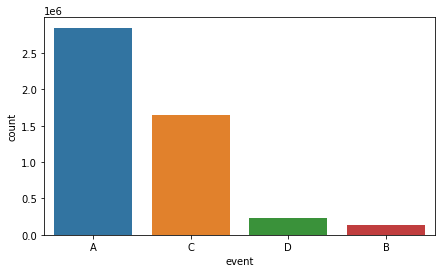

In [11]:
plt.figure(figsize=(7,4))
sns.countplot(train_df.event);

# 2. Data Cleaning
Most columns are fine, but gsr (galvanic skin response) is an exception. There are lots of abnormal values in gsr that we should deal with.

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


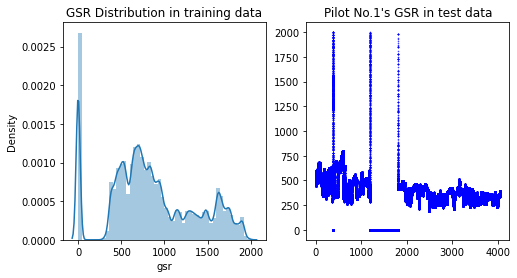

In [12]:
plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
sns.distplot(train_df.gsr)
plt.title('GSR Distribution in training data');
plt.subplot(1,2,2)

example=test_df[test_df.pilot==1].sort_values(by='time').reset_index()
exp_colors={'SS':'g','CA':'r','DA':'k','LOFT':'b'}
for exp in example.experiment.unique():
    exp_chunk=example[example.experiment==exp]
    plt.scatter(exp_chunk.time,exp_chunk.gsr,alpha=0.5,marker='.',c=exp_colors[exp],s=1)
plt.title('Pilot No.1\'s GSR in test data');

We can observe that there are many zero values in gsr that do not look normal. Also, we can see most values do no change a lot, while at some point values fluctuate drastically. Hence, we should think of RobustScaler to normalize our data.

In [13]:
containsZero=[]
for pilot in tqdm(train_df.pilot.unique()):
    for exp in train_df[train_df.pilot==pilot].experiment.unique():
        chunk=train_df[(train_df.pilot==pilot) & (train_df.experiment==exp)]
        if (chunk.gsr==0).any():
            containsZero.append((pilot,exp))
list(map(lambda x:print('Detected zero gsr in Pilot No.{} Experiment:{}'.format(x[0],x[1])),containsZero));

  0%|          | 0/18 [00:00<?, ?it/s]

Detected zero gsr in Pilot No.102 Experiment:CA
Detected zero gsr in Pilot No.102 Experiment:DA
Detected zero gsr in Pilot No.102 Experiment:SS
Detected zero gsr in Pilot No.105 Experiment:DA
Detected zero gsr in Pilot No.7 Experiment:CA
Detected zero gsr in Pilot No.7 Experiment:DA


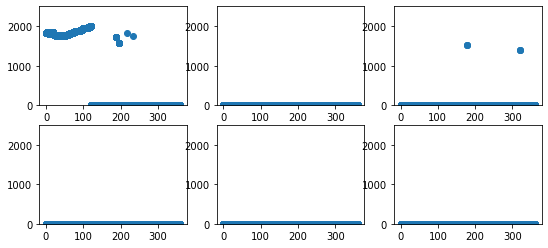

In [14]:
plt.figure(figsize=(9,4))
for i,(pilot,exp) in enumerate(containsZero):
    chunk=train_df[(train_df.pilot==pilot) & (train_df.experiment==exp)]
    plt.subplot(2,3,i+1)
    plt.scatter(chunk.time,chunk.gsr)
    plt.ylim([0,2500])

We should fill zeros with estimates. We can firstly try if we can get a non-zero mean value for the pilot and corresponding experiment and replace zeros with this value (102:CA, 102:SS). If we get all zeros in one experiment, consider use the pilot's mean value.

We can stop 0s from affecting mean calculations by replacing them into NANs. Also, we do the same to the test dataset.

In [15]:
train_df.loc[train_df.gsr==0,'gsr']=np.nan
test_df.loc[test_df.gsr==0,'gsr']=np.nan

gsr_reference=pd.pivot_table(train_df[['gsr','event','pilot']],index='pilot',columns=['event'],aggfunc=np.mean)
gsr_reference.head()

gsr                                       
event            A            C            D            B
pilot                                                    
1       713.021729   801.846375   673.309509   860.992859
2      1095.697998  1279.048950  1225.643066  1074.893066
3       806.885376   802.571777   695.225464  1004.742981
4       880.521240   939.883728   876.848083   880.694031
5      1526.038208  1445.909668  1705.614380  1498.331055

Then we replace NAN values using estimates.

In [16]:
for i,(pilot,exp) in enumerate(containsZero):
    chunk=train_df[(train_df.pilot==pilot) & (train_df.experiment==exp)]
    if not np.isnan(chunk.gsr).all():
        train_df.loc[chunk[np.isnan(chunk.gsr)].index,'gsr']=chunk.gsr.mean()
    else:
        train_df.loc[chunk.index,'gsr']=gsr_reference.loc[pilot].mean()

As we do not have 'event' column in test data while test data contains considerable 0s in gsr, we use mean value in training data to fill.

In [17]:
for pilot in tqdm(test_df.pilot.unique()):
    chunk=test_df[test_df.pilot==pilot]
    if (np.isnan(chunk.gsr)).any():
        test_df.loc[chunk[np.isnan(chunk.gsr)].index,'gsr']=gsr_reference.loc[pilot].mean()

  0%|          | 0/18 [00:00<?, ?it/s]

# 3. Feature Engineering

To be honest, we are not eeg specialists, and have little domain knowledge of EEG. However, after reading essays, we realized it might be useful to filter out high-frequency signals, which might be random noise. To filter signals, we should use scipy.signal package. We suspect existence of sweat artifact but cannot confirm this based on our knowledge.

In [18]:
from scipy import signal

Let's try it out first! For illustration purposes, we pick up the first 500 rows of eeg_fp1 data from pilot No.1 and experiment CA.

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


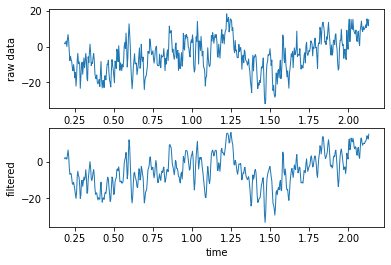

In [19]:
signal_example=chunk_sorted[chunk_sorted.experiment=='CA'].iloc[0:500]

plt.figure(figsize=(6,4))
d=signal_example.eeg_fp1
b, a = signal.butter(2,0.6) 

y = signal.filtfilt(b, a, d, padlen=150)

plt.subplot(2,1,1)
sns.lineplot(signal_example.time,d,hue=signal_example.event,linewidth=1)
plt.gca().get_legend().remove()
plt.ylabel('raw data')

plt.subplot(2,1,2)
sns.lineplot(signal_example.time,y,hue=signal_example.event,linewidth=1)
plt.gca().get_legend().remove()
plt.ylabel('filtered');

Much clearer! Now let's apply this filter to all EEG features.

In [20]:
eeg_features = ["eeg_fp1", "eeg_f7", "eeg_f8", "eeg_t4", "eeg_t6", "eeg_t5", "eeg_t3",
                "eeg_fp2", "eeg_o1", "eeg_p3", "eeg_pz", "eeg_f3", "eeg_fz", "eeg_f4",
                "eeg_c4", "eeg_p4", "eeg_poz", "eeg_c3", "eeg_cz", "eeg_o2"]


def signal_filter(df):
    for pilot in tqdm(df.pilot.unique()):
        for exp in df[df.pilot==pilot].experiment.unique():
            chunk=df[(df.pilot==pilot) & (df.experiment==exp)].sort_values(by='time')
            for eeg in eeg_features:
                df.loc[chunk.index,eeg]=pd.Series(data=signal.filtfilt(b, a, chunk[eeg], padlen=150),index=chunk.index,dtype='float32')
signal_filter(train_df)
signal_filter(test_df)

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

We assigned a groupid for each row. We can therefore calculate some features out of groups, such as min, max, standard deviation and mean, which might help model predict more accurately. If we assign groups with large interval, we risk new features being too general to catch important details. Inversely, if we have lots of groups, it is likely we end up overfitting after a looooooooooog time of calculation.

Due to Kaggle kernel time restrictions, the interval in this kernel is for illustration purpose only.

WARNING: This code takes a VERY long time (possible days and nights) to run when we have small interval (as we will have lots of groups to deal with).

In [21]:
features_to_group=['gsr','r','ecg']
grouped_features=['_grouped_'+e for e in ['max','min','std','mean']]
new_features=[e+f for e in features_to_group for f in grouped_features]

def extract_group_feature(df):
    for nfeature in new_features:
        df[nfeature]=np.nan
    
    for gid in tqdm(df.groupid.unique()):
        chunk=df[df.groupid==gid]
        for feature in features_to_group:
            max_value=chunk[feature].max()
            min_value=chunk[feature].min()
            std_value=chunk[feature].std()
            mean_value=chunk[feature].mean()

            if np.isnan(std_value):
                std_value=0

            df.loc[chunk.index,[feature+e for e in grouped_features]]=[max_value,min_value,std_value,mean_value]
extract_group_feature(train_df)
extract_group_feature(test_df)

  0%|          | 0/106 [00:00<?, ?it/s]

  0%|          | 0/302 [00:00<?, ?it/s]

We finally normalize our data. Remember to use RobustScaler to deal with outliers and normalize on pilot level and apply trained scaler to normalize test data so as to avoid data leakage.

In [22]:
all_features = eeg_features+["ecg", "r", "gsr"]+new_features
from sklearn.preprocessing import RobustScaler

for pilot in tqdm(train_df.pilot.unique()):
    scaler=RobustScaler()
    chunk=train_df.loc[train_df.pilot==pilot,all_features]
    train_df.loc[chunk.index,all_features]=scaler.fit_transform(chunk).astype('float32')
    
    test_chunk=test_df.loc[test_df.pilot==pilot,all_features]
    test_df.loc[test_chunk.index,all_features]=scaler.transform(test_chunk).astype('float32')

  0%|          | 0/18 [00:00<?, ?it/s]

Memory Optimization: LightGBM takes a numpy matrix with dtype float32. If we are parsing a matrix with dtype other than float32, LightGBM will make a copy of our data and try converting it to float32, when memory usage can peak twice the size of input dataset and result in a memory error. Hence, we should make adjustments to avoid memory waste.

In [23]:
try:
    train_group=train_df.groupid
    train_target=train_df.event
    train_df.drop(columns=[ 'crew', 'experiment', 'time', 'seat','pilot','groupid','event'],inplace=True)
    test_id=test_df.id
    test_df.drop(columns=['id', 'crew', 'experiment', 'time', 'seat','pilot','groupid'],inplace=True)

except:
    pass
for column in test_df.columns:
    train_df[column]=train_df[column].astype('float32')
    test_df[column]=test_df[column].astype('float32')

In [24]:
assert(train_df.values.dtype=='float32')
assert(test_df.values.dtype=='float32')

This part is used for environment saving/loading so that we do not have to run all above and wait for 24hrs like idiots. By the way, pickle files are far faster to read and save and more space-efficient than csv files.

In [25]:
train_df.to_pickle('train.pkl')
test_df.to_pickle('test.pkl')

# 4. Model Training
To evaluate model performance, we should split data into training set and validation set. As mentioned above, we are doing this on a coarser level.

In [26]:
dic={'A': 0, 'B': 1, 'C': 2, 'D': 3}
X_train,X_val,y_train,y_val = train_test_split_group(train_df, train_target, random_state=140, grouping_reference=train_group, train_size=0.8)  
#train_test_split(train_df.drop('event',axis=1)[all_features],train_df.event.apply(lambda x:dic.get(x)), test_size=0.2, random_state=420)

In [27]:
%%time

def print_metrics(model):
    y_pred_train = model.predict(X_train)
    print(multilabel_confusion_matrix(y_train, y_pred_train,
                                labels=["A", "B", "C", "D"]))
    print(classification_report(y_train, y_pred_train, target_names=["A", "B", "C", "D"]))


    y_pred_val = model.predict(X_val)
    print(multilabel_confusion_matrix(y_val, y_pred_val,
                                      labels=["A", "B", "C", "D"]))
    print(classification_report(y_val, y_pred_val, target_names=["A", "B", "C", "D"]))
    report = classification_report(y_val, y_pred_val, target_names=["A", "B", "C", "D"], output_dict=True)
    A_recall = report["A"]["recall"]
    D_precision = report["D"]["precision"]
    mean = (A_recall + D_precision) / 2
    print(f'Recall of class A: {A_recall}')
    print(f'Precision of class D: {D_precision}')
    print(f'Mean: {mean}')
    return report
    
def compute_scores(scores, model, model_name, x_train_, y_train_, x_val_, y_val_):
    print(f'Model {model_name} Training Accuracy: ', model.score(x_train_, y_train_))
    print(f'Model {model_name} Validation Accuracy: ', model.score(x_val_, y_val_))
    print(f"Model {model_name} Training log loss: ", log_loss(y_train_, model.predict_proba(x_train_)))
    print(f"Model {model_name} Validation log loss: ", log_loss(y_val_, model.predict_proba(x_val_)))
    scores["train_acc"].append(model.score(x_train_, y_train_))
    scores["val_acc"].append(model.score(x_val_, y_val_))
    scores["train_loss"].append(log_loss(y_train_, model.predict_proba(x_train_)))
    scores["val_loss"].append(log_loss(y_val_, model.predict_proba(x_val_)))
    return scores

def eval_f1_score(y_true, y_pred):
    labels = ["A", "B", "C", "D"]
    y_pred = y_pred.reshape(4, -1).T
    y_pred = y_pred.argmax(axis=1)
    f_score = f1_score(y_true , y_pred,  average='weighted', labels=labels)
    return 'f1_score', f_score, True

def eval_A_recall_D_precision(y_true, y_pred):
    y_pred = y_pred.reshape(4, -1).T
    y_pred = y_pred.argmax(axis=1)
    metrics = precision_recall_fscore_support(y_true, y_pred, average=None)
    A_recall = metrics[1][0]
    D_precision = metrics[0][3]
    mean = (A_recall + D_precision) / 2
    return "mean_A_recall_D_precision", mean, True

scores = {}
scores["train_acc"] = []
scores["val_acc"] = []
scores["train_loss"] = []
scores["val_loss"] = []

CPU times: user 8 µs, sys: 0 ns, total: 8 µs
Wall time: 12.6 µs


In [28]:
%%time

"""
Did not meet early stopping. Best iteration is:
[3000]	valid_0's multi_logloss: 0.0102433	valid_0's f1_score: 0.996851
{'learning_rate': 0.04, 'max_depth': 10, 'num_leaves': 27, 'min_data_in_leaf': 156, 'feature_fraction': 0.515153563909097, 'subsample': 0.23540514411668698, 'objective': 'multiclass', 'random_state': 314, 'n_estimators': 3000, 'early_stopping_rounds': 10, 'class_weight': 'balanced', 'verbose': -1}
F1_score: 0.9968514264214164     Log Loss: 0.010243280790404225
Took 6079.48428273201 seconds

"""

opt_params = {'learning_rate': 0.04,
              'max_depth': 10,
              'num_leaves': 27,
              'min_data_in_leaf': 156,
              'feature_fraction': 0.515153563909097,
              'subsample': 0.23540514411668698,
              'objective': 'multiclass',
              'random_state': 314,
              'n_estimators': 3000,
              'class_weight': 'balanced',
              "early_stopping_rounds": 50,
              'verbose': -1}

lgbm = LGBMClassifier(boosting_type = 'gbdt',
                      **opt_params)
start = time.time()
lgbm.fit(X_train, y_train, 
         eval_set=[(X_train, y_train), (X_val, y_val)],
         eval_metric=[eval_A_recall_D_precision, "multi_logloss"],
         verbose=300)
#     print(lgbm.best_score_)
score_train = lgbm.best_score_['training']['mean_A_recall_D_precision']
multi_logloss_train = lgbm.best_score_['training']['multi_logloss']
score_val = lgbm.best_score_['valid_1']['mean_A_recall_D_precision']
multi_logloss_val = lgbm.best_score_['valid_1']['multi_logloss']

# print(f'A_recall_D_precision_Train: {score_train}     Log_Loss_Train: {multi_logloss_train}')
# print(f'A_recall_D_precision_Val: {score_val}     Log_Loss_Val: {multi_logloss_val}')
# print(f"Took {time.time() - start} seconds")
# print("-------------------")

# lgbm_scores = compute_scores(scores, lgbm, "LGBM", X_train, y_train, X_val, y_val)
# class_report = print_metrics(lgbm)

# print(lgbm.get_lgbm_params())

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:156: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] early_stopping_round is set=50, early_stopping_rounds=50 will be ignored. Current value: early_stopping_round=50
[LightGBM] [Warning] feature_fraction is set=0.515153563909097, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.515153563909097
[LightGBM] [Warning] min_data_in_leaf is set=156, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=156
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[145]	training's multi_logloss: 0.287104	training's mean_A_recall_D_precision: 0.355359	valid_1's multi_logloss: 0.769887	valid_1's mean_A_recall_D_precision: 0.411404
CPU times: user 29min 23s, sys: 11.7 s, total: 29min 34s
Wall time: 12min 32s


In [29]:
%%time
# test_id = test_df.id
test_pred = lgbm.predict_proba(test_df)

print('--Submission mounting has started')
submission = pd.DataFrame({
    'id': test_id,
    'A': test_pred[:, 0],
    'B': test_pred[:, 1],
    'C': test_pred[:, 2],
    'D': test_pred[:, 3]
})
print("Finished mounting submission")

--Submission mounting has started
Finished mounting submission
CPU times: user 11min 30s, sys: 7.8 s, total: 11min 38s
Wall time: 3min 10s


In [30]:
A_values = submission.drop("id", axis=1).idxmax(axis=1)[submission.drop("id", axis=1).idxmax(axis=1) == "A"]
B_values = submission.drop("id", axis=1).idxmax(axis=1)[submission.drop("id", axis=1).idxmax(axis=1) == "B"]
C_values = submission.drop("id", axis=1).idxmax(axis=1)[submission.drop("id", axis=1).idxmax(axis=1) == "C"]
D_values = submission.drop("id", axis=1).idxmax(axis=1)[submission.drop("id", axis=1).idxmax(axis=1) == "D"]
print(len(A_values))
print(len(B_values))
print(len(C_values))
print(len(D_values))

16934754
142583
887806
0


In [31]:
submission.to_csv('submission.csv', index = False)